In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '..')
from analysis.analysis_utils import *
from analysis.plot_utils import *
import pandas as pd
from datasets import load_dataset
from collections import Counter
import matplotlib.pyplot as plt

In [5]:
all_df = prepare_df()

# Add the debate leak check
checks_df = load_all_records_into_df('debate_checks').drop_duplicates(['run_id_debate_checks', 'record_id_debate_checks'], keep='last')
all_df = all_df.merge(checks_df, left_on=['debate_run_id_verdicts', 'record_id_verdicts'], right_on=['run_id_debate_checks', 'record_id_debate_checks'], how='left')

all_df['raw_verdict_response'] = all_df['judge_verdict_verdicts'].apply(lambda x: x['raw_response'])



In [6]:
def check_for_vague_phrases(x):
    if 'more plausible' in x or 'more consistent' in x:
        return True
    else:
        return False

all_df['verdict_uses_vague_phrase'] = all_df['raw_verdict_response'].apply(lambda x: check_for_vague_phrases(x))


In [7]:
def get_argument_lengths(debate_history):
    lengths = []
    try:
        for entry in debate_history:
            entry_len = len(entry['raw_response'].split())
            lengths.append(entry_len)
    except:
        return None

    return np.array(lengths)

all_df['debate_argument_lengths'] = all_df['debate_history_debates'].apply(lambda x: get_argument_lengths(x))
all_df = all_df[all_df['debate_argument_lengths'].notnull()]

In [8]:
all_df['verdict_contains_equal'] = all_df['raw_verdict_response'].apply(lambda x: '=' in x)

In [9]:
all_df.shape

(24015, 92)

## Look at single run

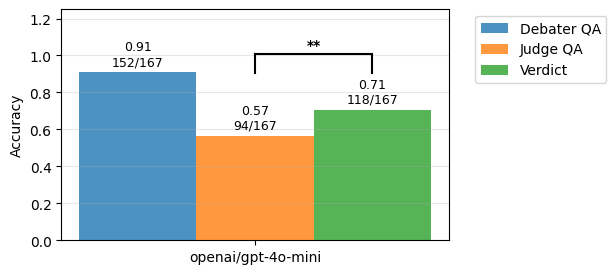

In [ ]:

single_verdict =  ['k26y5y6'] # grok-4-fast as debater (4 choice)
verdicts_df = all_df[all_df['verdict_run_id_verdicts'].isin(single_verdict)]
# 
verdicts_df = verdicts_df[verdicts_df['has_leak_debate_checks'] == False]

acc_gpqa = aggregate_by_fields(verdicts_df, ['config_judge_model_verdicts'])


ax, plt = plot_accuracy_bars_single(acc_gpqa, show_sig=True)

In [ ]:
# verdicts_df[['is_correct_qa_debater', 'is_correct_qa_judge', 'is_correct_verdict']].value_counts().reset_index()
verdicts_df[['is_correct_qa_judge', 'is_correct_verdict']].value_counts().reset_index()


,is_correct_qa_judge,is_correct_verdict,count
0,True,True,73
1,False,True,44
2,False,False,28
3,True,False,21


In [ ]:
# tft are the main successes and ttf are the main failures
tft = verdicts_df[(verdicts_df['is_correct_qa_debater'] == True) & (verdicts_df['is_correct_qa_judge'] == False) & (verdicts_df['is_correct_verdict'] == True)]
ttf = verdicts_df[(verdicts_df['is_correct_qa_debater'] == True) & (verdicts_df['is_correct_qa_judge'] == True) & (verdicts_df['is_correct_verdict'] == False)]

In [ ]:
tft['record_id_verdicts'].tolist()[:2]

['ky8qkpj', 'f1jkw43']

In [ ]:
ttf['record_id_verdicts'].tolist()[:2]

['uwndxoj', '8uee8as']

### Analysis

##### Does phrase vagueness in the judge verdict indicate correctness?

In [10]:
verdicts_df = all_df[all_df['config_judge_model_verdicts'] == 'openai/gpt-4o-mini'].copy()


In [11]:
verdicts_df[['verdict_uses_vague_phrase', 'config_judge_model_verdicts']].value_counts().reset_index()

,verdict_uses_vague_phrase,config_judge_model_verdicts,count
0,False,openai/gpt-4o-mini,4190
1,True,openai/gpt-4o-mini,785


In [12]:
tft = verdicts_df[(verdicts_df['is_correct_qa_debater'] == True) & (verdicts_df['is_correct_qa_judge'] == False) & (verdicts_df['is_correct_verdict'] == True)]
ttf = verdicts_df[(verdicts_df['is_correct_qa_debater'] == True) & (verdicts_df['is_correct_qa_judge'] == True) & (verdicts_df['is_correct_verdict'] == False)]

In [13]:
tft['verdict_uses_vague_phrase'].value_counts(normalize=True)

verdict_uses_vague_phrase
False    0.788609
True     0.211391
Name: proportion, dtype: float64

In [14]:
ttf['verdict_uses_vague_phrase'].value_counts(normalize=True)

verdict_uses_vague_phrase
False    0.795539
True     0.204461
Name: proportion, dtype: float64

Conclusion: inclusion of these vague phrases does not correlate with working or not working

### Is = sign correlated with correctness?

In [15]:
tft['verdict_contains_equal'].value_counts(normalize=True)

verdict_contains_equal
False    0.622125
True     0.377875
Name: proportion, dtype: float64

In [16]:
ttf['verdict_contains_equal'].value_counts(normalize=True)

verdict_contains_equal
False    0.693309
True     0.306691
Name: proportion, dtype: float64

In [17]:
all_df[['verdict_contains_equal', 'is_correct_verdict']].value_counts(normalize=True).reset_index()

,verdict_contains_equal,is_correct_verdict,proportion
0,False,True,0.350031
1,False,False,0.326463
2,True,True,0.216073
3,True,False,0.107433


In [18]:
all_df[all_df['verdict_contains_equal'] == True]['is_correct_verdict'].value_counts(normalize=True)

is_correct_verdict
True     0.667911
False    0.332089
Name: proportion, dtype: float64

In [19]:
all_df[all_df['verdict_contains_equal'] == False]['is_correct_verdict'].value_counts(normalize=True)

is_correct_verdict
True     0.51742
False    0.48258
Name: proportion, dtype: float64

##### Does judge verdict length correlate with correctness?

In [21]:
all_df['verdict_response_len'] = all_df['raw_verdict_response'].apply(lambda x: len(x.split()))

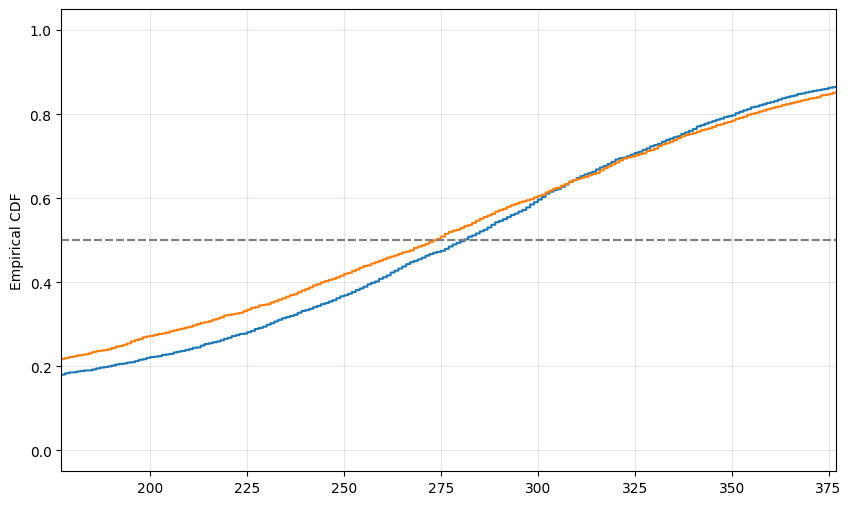

In [74]:
tft = all_df[(all_df['is_correct_qa_debater'] == True) & (all_df['is_correct_qa_judge'] == False) & (all_df['is_correct_verdict'] == True)]
ttf = all_df[(all_df['is_correct_qa_debater'] == True) & (all_df['is_correct_qa_judge'] == True) & (all_df['is_correct_verdict'] == False)]

# tft_sorted = np.sort(tft['verdict_response_len'].dropna())
# ttf_sorted = np.sort(ttf['verdict_response_len'].dropna())

def cdf(data, labels=None, ax=None, xlim_percentiles=None, xlim_ranges=None, xlim_window_from_median=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    if not labels:
        labels = [str(i) for i in range(len(data))]

    for idx, d in enumerate(data):
        d = np.sort(d.dropna().copy())
        ax.plot(d, np.arange(1, len(d) + 1) / len(d), label=f"{labels[idx]} (n={len(d)})")
        # plot dash line at .5 on y axis
        ax.axhline(y=0.5, color='gray', linestyle='--')

        
    # d1 = np.sort(d1.dropna().copy())
    # d2 = np.sort(d2.dropna().copy())
    # ax.plot(d1, np.arange(1, len(d1) + 1) / len(d1), label=f'Success (n={len(d1)})')
    # ax.plot(d2, np.arange(1, len(d2) + 1) / len(d2), label=f'Failure (n={len(d2)})')
    ax.set_ylabel('Empirical CDF')
    ax.grid(True, alpha=0.3)
    
    if xlim_percentiles:
        combined = np.concatenate(data)
        x1, x2 = np.percentile(combined, xlim_percentiles[0]), np.percentile(combined, xlim_percentiles[1])
        ax.set_xlim(x1, x2)
    elif xlim_ranges:
        ax.set_xlim(xlim_ranges[0], xlim_ranges[1])
    elif xlim_window_from_median:
        combined = np.concatenate(data)
        combined_median = np.percentile(combined, 50)
        ax.set_xlim(combined_median + xlim_window_from_median[0], combined_median + xlim_window_from_median[1])
    
    return ax

cdf((tft['verdict_response_len'], ttf['verdict_response_len']), xlim_window_from_median=[-100, 100])
plt.show()

### Does debater argument length correlate with correctness?

In [76]:
verdicts_df = all_df[all_df['config_num_choices_debates'] == 2].copy()
verdicts_df.shape

(5885, 93)

In [77]:
verdicts_df['total_argument_lengths'] = verdicts_df['debate_argument_lengths'].apply(lambda x: x.sum())
verdicts_df['absolute_length_differences'] = verdicts_df['debate_argument_lengths'].apply(lambda x: abs(x[0] - x[1]))
verdicts_df['correct_option_length'] = verdicts_df.apply(lambda row: row['debate_argument_lengths'][row['correct_idx_verdicts']], axis=1)
verdicts_df['incorrect_option_length'] = verdicts_df.apply(lambda row: row['debate_argument_lengths'][1 - row['correct_idx_verdicts']], axis=1)
verdicts_df['correct_minus_incorrect_option_length'] = verdicts_df['correct_option_length'] - verdicts_df['incorrect_option_length']
verdicts_df['chosen_option_length'] = verdicts_df.apply(lambda row: row['debate_argument_lengths'][row['parsed_answer_verdicts']], axis=1)
verdicts_df['unchosen_option_length'] = verdicts_df.apply(lambda row: row['debate_argument_lengths'][1 - row['parsed_answer_verdicts']], axis=1)
verdicts_df['chosen_minus_unchosen_option_length'] = verdicts_df['chosen_option_length'] - verdicts_df['unchosen_option_length']

cols = ['total_argument_lengths', 'absolute_length_differences', 'correct_option_length', 'incorrect_option_length', 'correct_minus_incorrect_option_length', 'chosen_option_length', 'unchosen_option_length', 'chosen_minus_unchosen_option_length']

In [128]:
# Generalizing this to 4 choices
verdicts_df = all_df[all_df['config_num_choices_debates'] == 4].copy()

verdicts_df['average_incorrect_option_length'] = verdicts_df.apply(lambda row: np.mean(np.delete(row['debate_argument_lengths'], row['correct_idx_verdicts'])), axis=1)
verdicts_df['average_unchosen_option_length'] = verdicts_df.apply(lambda row: np.mean(np.delete(row['debate_argument_lengths'], row['parsed_answer_verdicts'])), axis=1)


verdicts_df['total_argument_lengths'] = verdicts_df['debate_argument_lengths'].apply(lambda x: x.sum())
verdicts_df['absolute_length_differences'] = verdicts_df['debate_argument_lengths'].apply(lambda x: abs(x[0] - x[1]))  # just for first 2 options
verdicts_df['correct_option_length'] = verdicts_df.apply(lambda row: row['debate_argument_lengths'][row['correct_idx_verdicts']], axis=1)
verdicts_df['incorrect_option_length'] = verdicts_df['average_incorrect_option_length'] # using the average incorrect 
verdicts_df['correct_minus_incorrect_option_length'] = verdicts_df['correct_option_length'] - verdicts_df['incorrect_option_length']
verdicts_df['chosen_option_length'] = verdicts_df.apply(lambda row: row['debate_argument_lengths'][row['parsed_answer_verdicts']], axis=1)
verdicts_df['unchosen_option_length'] = verdicts_df['average_unchosen_option_length']
verdicts_df['chosen_minus_unchosen_option_length'] = verdicts_df['chosen_option_length'] - verdicts_df['unchosen_option_length']

cols = ['total_argument_lengths', 'absolute_length_differences', 'correct_option_length', 'incorrect_option_length', 'correct_minus_incorrect_option_length', 'chosen_option_length', 'unchosen_option_length', 'chosen_minus_unchosen_option_length']

In [129]:
tft = verdicts_df[(verdicts_df['is_correct_qa_debater'] == True) & (verdicts_df['is_correct_qa_judge'] == False) & (verdicts_df['is_correct_verdict'] == True)]
ttf = verdicts_df[(verdicts_df['is_correct_qa_debater'] == True) & (verdicts_df['is_correct_qa_judge'] == True) & (verdicts_df['is_correct_verdict'] == False)]

In [130]:
tft[cols].describe()

,total_argument_lengths,absolute_length_differences,correct_option_length,incorrect_option_length,correct_minus_incorrect_option_length,chosen_option_length,unchosen_option_length,chosen_minus_unchosen_option_length
count,2385.000000,2385.000000,2385.000000,2385.000000,2385.000000,2385.000000,2385.000000,2385.000000
mean,1223.298952,95.912788,267.351363,318.678756,-51.327393,267.351363,318.678756,-51.327393
std,1158.465461,345.191195,236.927142,326.418922,231.790995,236.927142,326.418922,231.790995
min,493.000000,0.000000,111.000000,127.333333,-2461.000000,111.000000,127.333333,-2461.000000
25%,725.000000,12.000000,171.000000,182.666667,-34.000000,171.000000,182.666667,-34.000000
50%,795.000000,24.000000,194.000000,201.666667,-13.333333,194.000000,201.666667,-13.333333
75%,1025.000000,49.000000,246.000000,257.000000,4.333333,246.000000,257.000000,4.333333
max,12043.000000,3065.000000,3872.000000,3626.000000,1653.000000,3872.000000,3626.000000,1653.000000


In [131]:
ttf[cols].describe()

,total_argument_lengths,absolute_length_differences,correct_option_length,incorrect_option_length,correct_minus_incorrect_option_length,chosen_option_length,unchosen_option_length,chosen_minus_unchosen_option_length
count,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000
mean,1026.248945,57.154852,236.150211,263.449578,-27.299367,259.748945,255.575738,4.173207
std,863.697868,224.254540,213.996300,231.250268,162.384610,241.913600,223.415586,170.547055
min,493.000000,0.000000,111.000000,127.333333,-2461.000000,109.000000,128.000000,-1336.333333
25%,735.000000,9.000000,173.000000,186.000000,-29.500000,186.000000,182.000000,-10.666667
50%,787.000000,18.500000,191.000000,199.666667,-12.500000,202.000000,196.000000,3.333333
75%,894.500000,36.000000,216.000000,227.333333,2.000000,231.000000,221.666667,19.333333
max,12043.000000,3065.000000,3872.000000,3626.000000,1653.000000,3821.000000,2966.333333,2356.000000


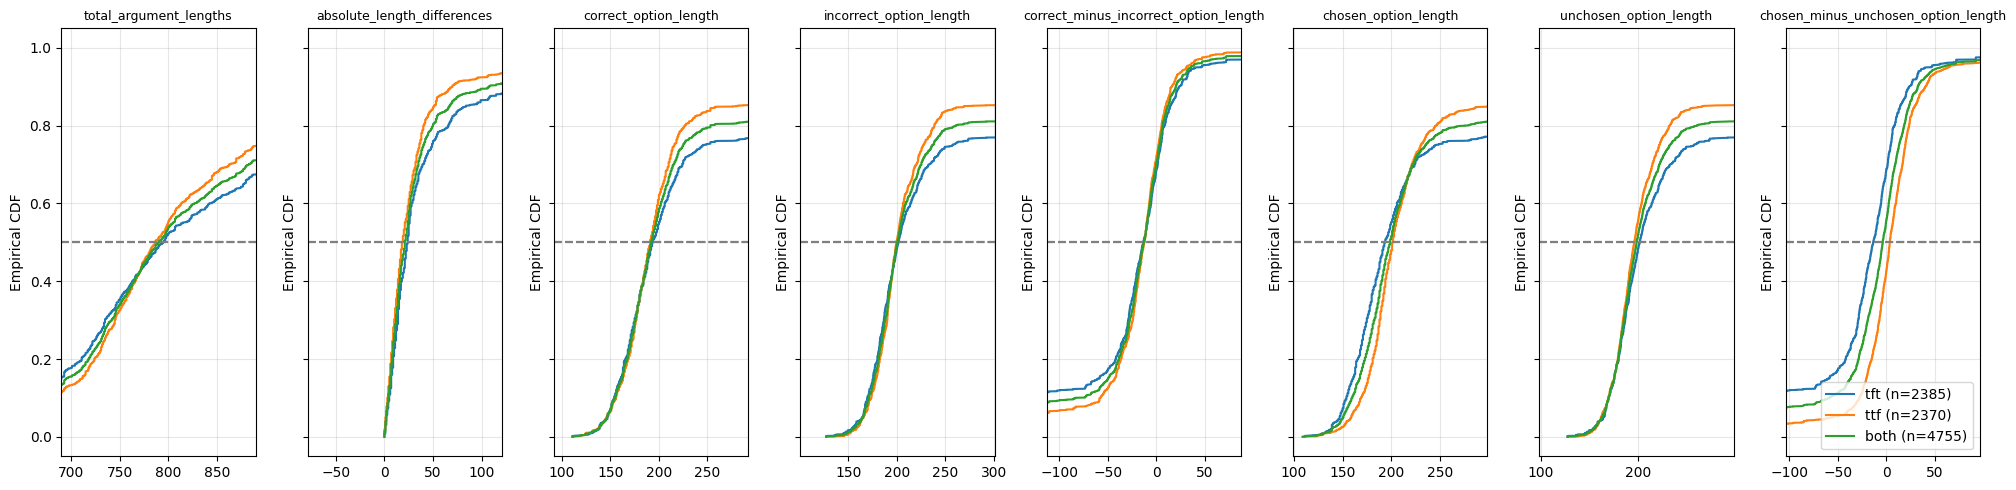

In [132]:
both = pd.concat([tft, ttf])

fig, ax = plt.subplots(1, len(cols), figsize=(20, 5), sharey=True)
for ax_index in range(len(cols)):
    cdf((tft[cols[ax_index]], ttf[cols[ax_index]], both[cols[ax_index]]), labels=['tft', 'ttf', 'both'], ax=ax[ax_index], xlim_window_from_median=[-100, 100])
    ax[ax_index].set_title(cols[ax_index], fontsize=9)
ax[ax_index].legend()
plt.tight_layout()
plt.show()

In [133]:
true_verdict = verdicts_df[(verdicts_df['is_correct_verdict'] == True)]
false_verdict = verdicts_df[(verdicts_df['is_correct_verdict'] == False)]

# true_verdict = verdicts_df[(verdicts_df['is_correct_qa_judge'] == True) & (verdicts_df['is_correct_verdict'] == True)]
# false_verdict = verdicts_df[(verdicts_df['is_correct_qa_judge'] == True) & (verdicts_df['is_correct_verdict'] == False)]

# true_verdict = verdicts_df[(verdicts_df['is_correct_qa_judge'] == False) & (verdicts_df['is_correct_verdict'] == True)]
# false_verdict = verdicts_df[(verdicts_df['is_correct_qa_judge'] == False) & (verdicts_df['is_correct_verdict'] == False)]

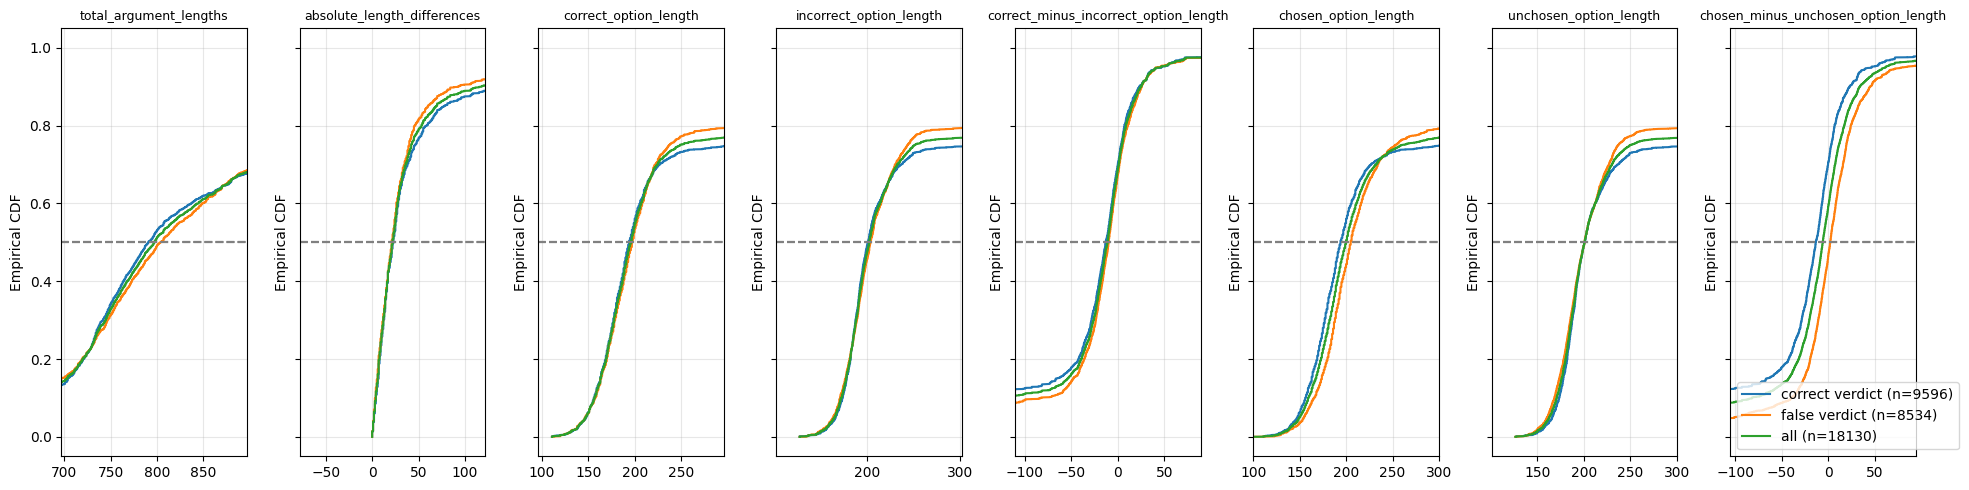

In [134]:
fig, ax = plt.subplots(1, len(cols), figsize=(20, 5), sharey=True)
for ax_index in range(len(cols)):
    cdf((true_verdict[cols[ax_index]], false_verdict[cols[ax_index]], verdicts_df[cols[ax_index]]), labels=['correct verdict', 'false verdict', 'all'], ax=ax[ax_index], xlim_window_from_median=[-100, 100])
    ax[ax_index].set_title(cols[ax_index], fontsize=9)
ax[ax_index].legend()
plt.tight_layout()
plt.show()

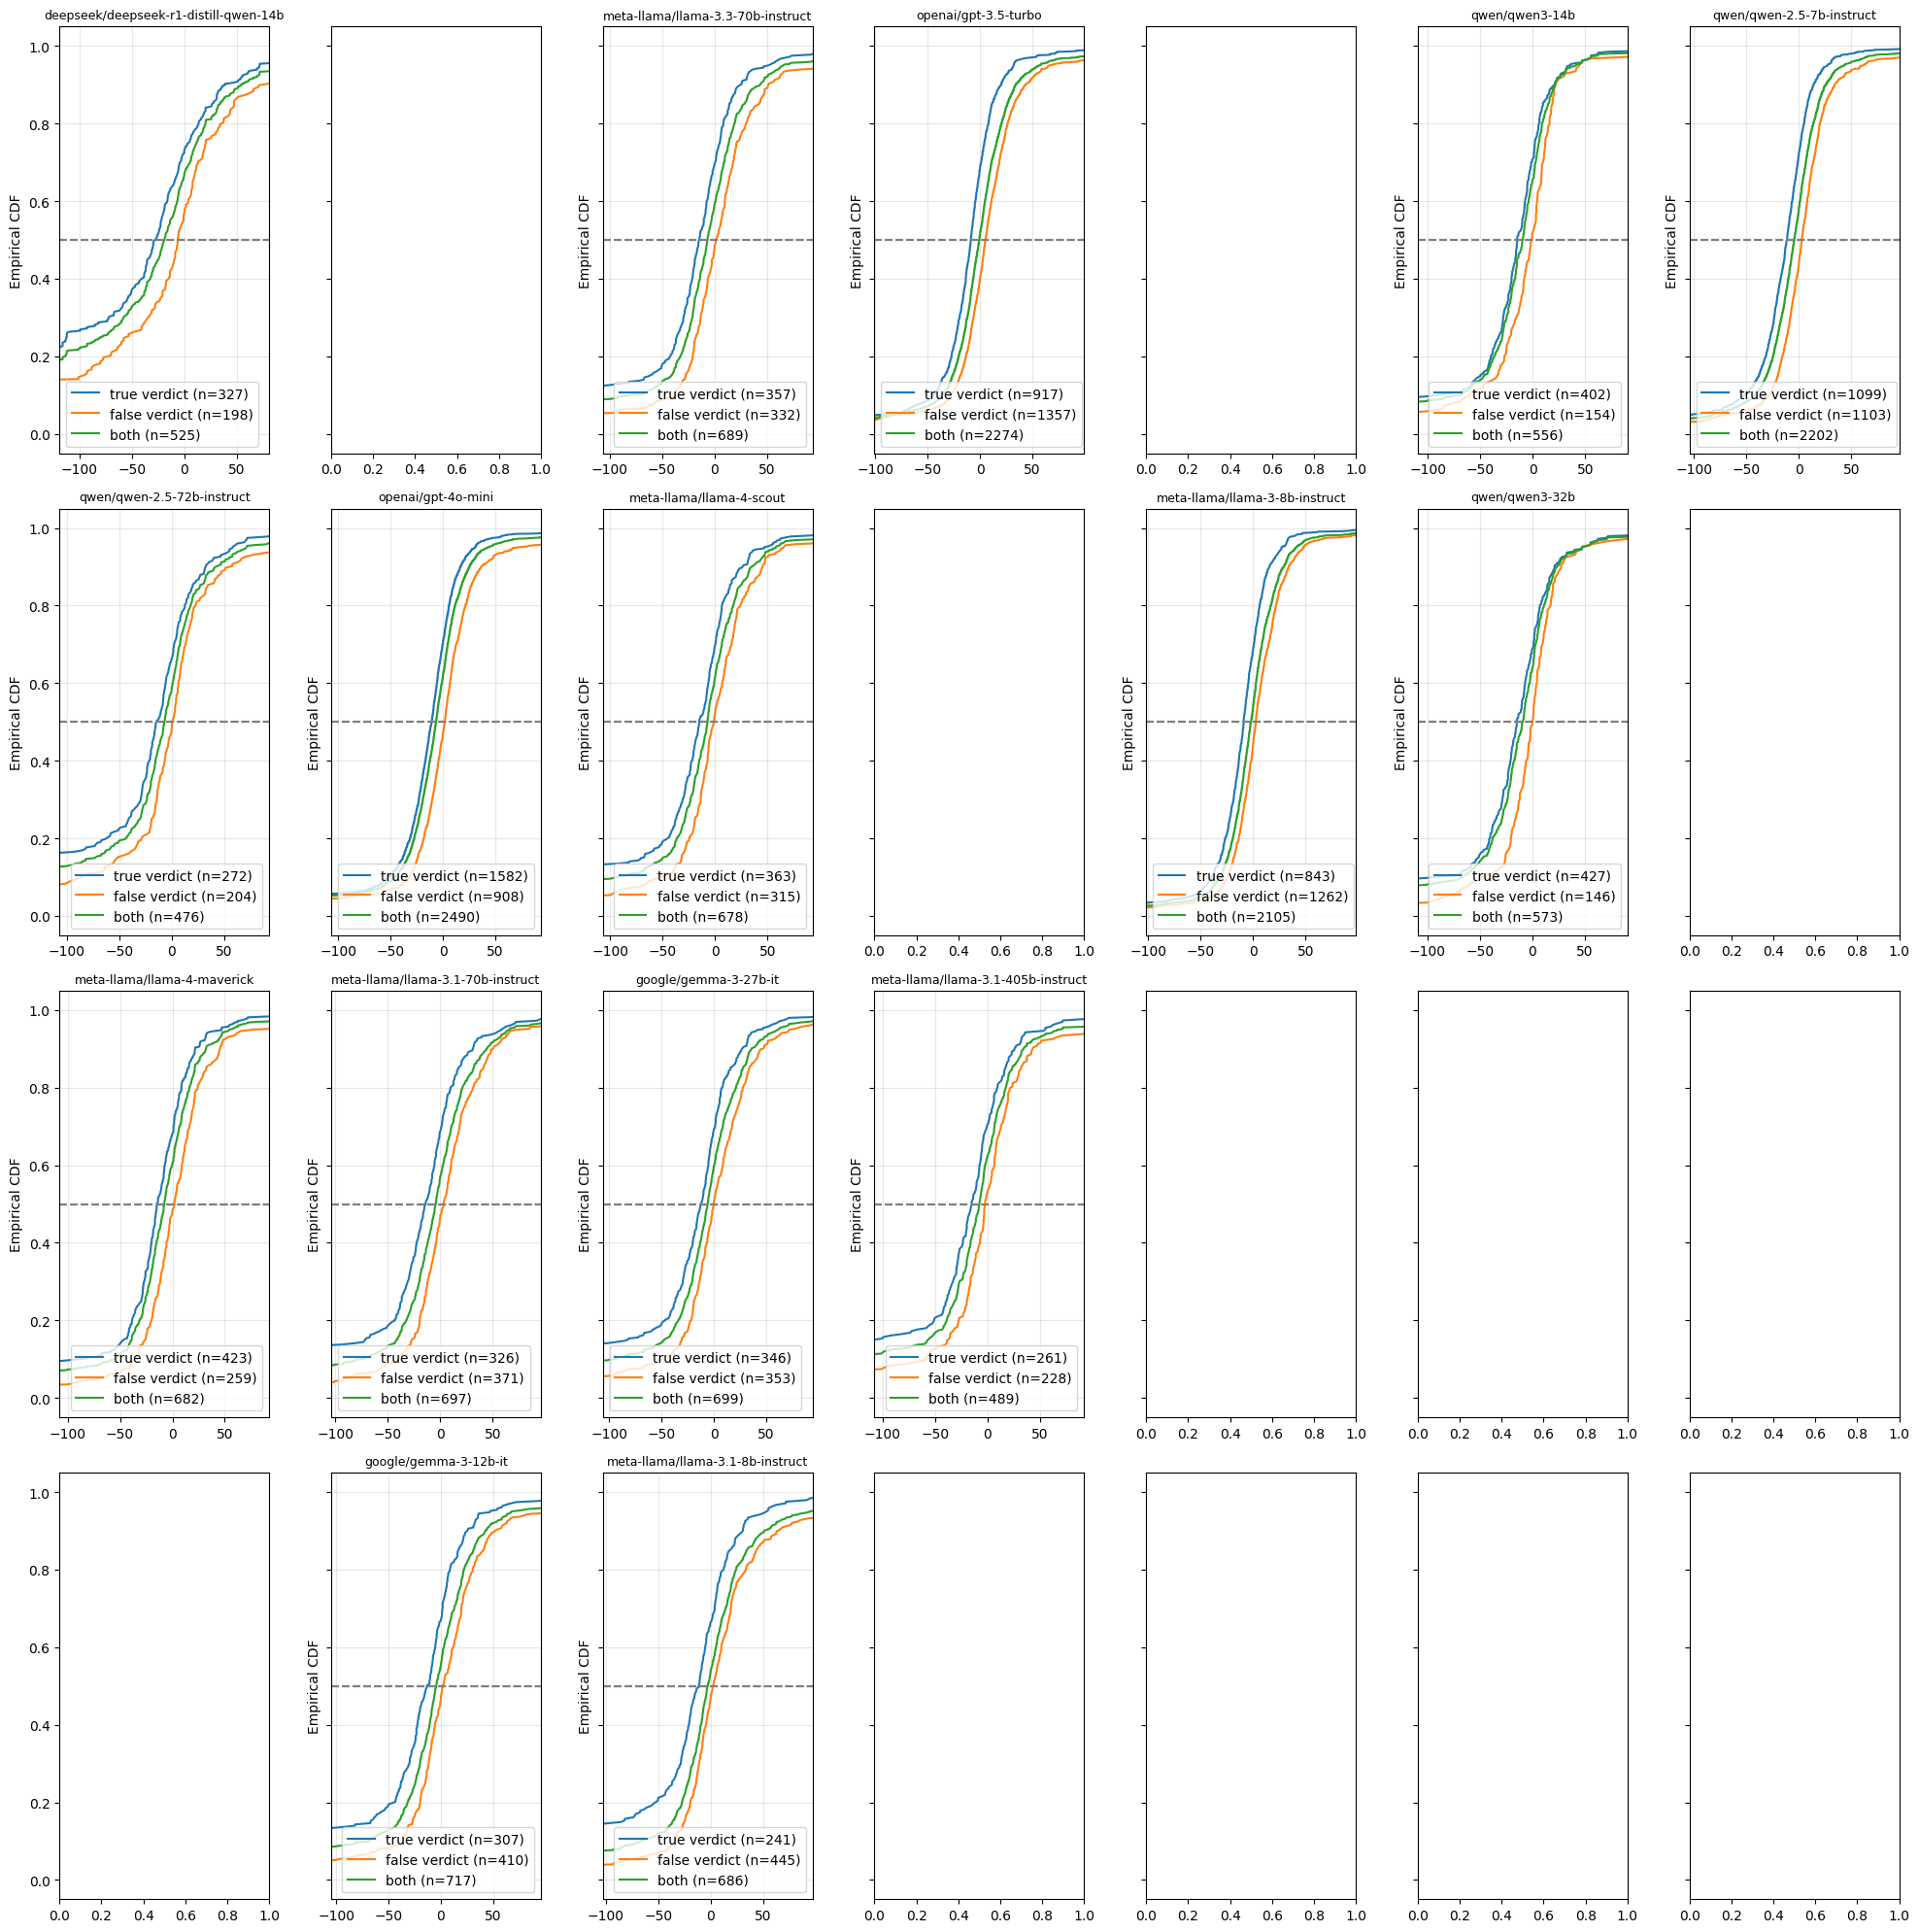

In [135]:
# Focusing on the chosen_minus_unchosen_option_length difference...let's look across all model
model_names = verdicts_df['config_judge_model_verdicts'].unique()
n_cols = 7
n_rows = (len(model_names) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows), sharey=True)
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

for ax_index, model_name in enumerate(model_names):
    subset_df = verdicts_df[verdicts_df['config_judge_model_verdicts'] == model_name]
    true_subset_df = subset_df[subset_df['is_correct_verdict'] == True]
    false_subset_df = subset_df[subset_df['is_correct_verdict'] == False]

    if true_subset_df.shape[0] < 100 or false_subset_df.shape[0] < 100:
        continue

    # if true_subset_df.shape[0] < 50 or false_subset_df.shape[0] < 50:
    #     continue

    # cdf((true_subset_df['correct_minus_incorrect_option_length'], false_subset_df['correct_minus_incorrect_option_length']), ax=axes[ax_index], xlim_window_from_median=[-100, 100])
    cdf((true_subset_df['chosen_minus_unchosen_option_length'], false_subset_df['chosen_minus_unchosen_option_length'], subset_df['chosen_minus_unchosen_option_length']), labels=['true verdict', 'false verdict', 'both'], ax=axes[ax_index], xlim_window_from_median=[-100, 100])

    axes[ax_index].set_title(model_name, fontsize=9)
    axes[ax_index].legend()

for i in range(len(model_names), len(axes)):
    axes[i].axis('off')

plt.tight_layout()